# Necessary Imports and Installations

In [ ]:
!pip install -U future

     |████████████████████████████████| 829 kB 5.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=31f219771d090897849f72c535f36b06bd7c3173fa9b1326fd0fc33e90ce6a18
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [22]:
import os, sys

from keras.models import Model
from __future__ import print_function, division
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, LSTM, GRU, Dense, Embedding

import numpy as np
from builtins import range, input
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt





In [23]:
try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass


In [24]:

n_size_batch = 64  
nepochs = 40 
dim_latent = 256  
samples_num = 10000  
num_wrds_max = 20000
dim_embedding = 100


In [25]:


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Where we Store the Data 
 Data Loading and keeping only a limited number of samples to avoid the model taking a long time to train.

In [26]:
sentences_inputs = [] #INITIAL LANGUAGE SENTENTCES
sentences_outputs = [] # LANGUAGE SENTNCES IN TARGETTED LANG
sentences_outputs_inputs = [] #offset by1f targ lang

In [27]:
b = 0
for line in open('/content/drive/My Drive/translation_files/hin.txt'):

  b += 1
  if b > samples_num:
    break


  if '\t' not in line:
    continue

#Splitting of i/p & translation
  sentences_input, translation, *rest = line.rstrip().split('\t')

  
  sentences_output = translation + ' <eos>'
  sentences_output_input = '<sos> ' + translation

  sentences_inputs.append(sentences_input)
  sentences_outputs.append(sentences_output)
  sentences_outputs_inputs.append(sentences_output_input)
print("number of samples:", len(sentences_inputs))

number of samples: 2952


# Tokenize
tokenize the inputs and outputs and fetch the word-to-index mapping for the i/p and o/p language. Filtering outputs such that we avoid removing special chars else it will be difficult to find end-of-sentence and start-of-sentence tokens. Padding the seqs to maxlen.

In [28]:

ips_toknisr = Tokenizer(num_words=num_wrds_max)
ips_toknisr.fit_on_texts(sentences_inputs)
seqs_ip = ips_toknisr.texts_to_sequences(sentences_inputs)


inputs_w2ind = ips_toknisr.word_index
print(' %s different i/p tokens were found.' % len(inputs_w2ind))

ip_mx_lnth = max(len(i) for i in seqs_ip)


op_tokniser = Tokenizer(num_words=num_wrds_max, filters='')
op_tokniser.fit_on_texts(sentences_outputs + sentences_outputs_inputs) # inefficient, oh well
target_sequences = op_tokniser.texts_to_sequences(sentences_outputs)
ip_target_seqs = op_tokniser.texts_to_sequences(sentences_outputs_inputs)

outputs_w2ind = op_tokniser.word_index
print(' %s different output tokens we re foun d' % len(outputs_w2ind))

op_num_wrds = len(outputs_w2ind) + 1


trgt_lenth_mx = max(len(sn) for sn in target_sequences)

 2429 different i/p tokens were found.
 3195 different output tokens we re foun d


In [29]:
ip_encdr = pad_sequences(seqs_ip, maxlen=ip_mx_lnth)
print("encoder_data.shape:", ip_encdr.shape)
print("encoder_data[0]:", ip_encdr[0])

ip_dcdr = pad_sequences(ip_target_seqs, maxlen=trgt_lenth_mx, padding='post')
print("decoder_data[0]:", ip_dcdr[0])
print("decoder_data.shape:", ip_dcdr.shape)

trgt_dcdrs = pad_sequences(target_sequences, maxlen=trgt_lenth_mx, padding='post')

encoder_data.shape: (2952, 22)
encoder_data[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1305]
decoder_data[0]: [   2 1521    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
decoder_data.shape: (2952, 26)


#storage of all pretrained word vecs

In [30]:

print('uploading word vectors   ')
wrd_to_vec = {}
with open(os.path.join('/content/drive/My Drive/translation_files/glove.6B.%sd.txt' % dim_embedding)) as o:
 
  for line in o:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    wrd_to_vec[word] = vec
print('%s word vectors were found' % len(wrd_to_vec))

uploading word vectors   
400000 word vectors were found


#Embedding Matrix & Embedding Layer

In [31]:
print('Filling pre-trained embeddings...')
num_words = min(num_wrds_max, len(inputs_w2ind) + 1)
embedding_matrix = np.zeros((num_words, dim_embedding))
for word, i in inputs_w2ind.items():
  if i < num_wrds_max:
    embedding_vector = wrd_to_vec.get(word)
    if embedding_vector is not None:
      
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [32]:

embedding_layer = Embedding(
  num_words,
  dim_embedding,
  weights=[embedding_matrix],
  input_length=ip_mx_lnth,
  
)


In [33]:
trgt_dcdrs1_hot = np.zeros(
  (
    len(sentences_inputs),
    trgt_lenth_mx,
    op_num_wrds
  ),
  dtype='float32'
)


for i, d in enumerate(trgt_dcdrs):
  for t, word in enumerate(d):
    if word > 0:
      trgt_dcdrs1_hot[i, t, word] = 1

# Model Build

In [34]:

ip_encdr_plshldr = Input(shape=(ip_mx_lnth,))
x = embedding_layer(ip_encdr_plshldr)
encoder = LSTM(
  dim_latent,
  return_state=True,
  
)
encoder_outputs, h, c = encoder(x)



encoder_states = [h, c]

In [35]:

ip_dcdr_plshldr = Input(shape=(trgt_lenth_mx,))


decoder_embedding = Embedding(op_num_wrds, dim_embedding)
ip_dcdr_x = decoder_embedding(ip_dcdr_plshldr)


decoder_lstm = LSTM(
  dim_latent,
  return_sequences=True,
  return_state=True,
  
)
op_dcdr, _, _ = decoder_lstm(
  ip_dcdr_x,
  initial_state=encoder_states
)

In [36]:
dense_dcdr = Dense(op_num_wrds, activation='softmax')
op_dcdr = dense_dcdr(op_dcdr)


model = Model([ip_encdr_plshldr, ip_dcdr_plshldr], op_dcdr)


def custom_loss(y_true, y_pred):
  
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')
  
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total


# Model Training 

Epoch 1/40
37/37 [==============================] - 7s 80ms/step - loss: 4.1878 - acc: 0.2676 - val_loss: 6.0163 - val_acc: 0.1485
Epoch 2/40
37/37 [==============================] - 2s 49ms/step - loss: 3.9953 - acc: 0.2814 - val_loss: 6.1226 - val_acc: 0.1493
Epoch 3/40
37/37 [==============================] - 2s 49ms/step - loss: 3.8547 - acc: 0.2927 - val_loss: 6.1644 - val_acc: 0.1523
Epoch 4/40
37/37 [==============================] - 2s 50ms/step - loss: 3.7210 - acc: 0.3091 - val_loss: 6.1889 - val_acc: 0.1593
Epoch 5/40
37/37 [==============================] - 2s 52ms/step - loss: 3.5859 - acc: 0.3219 - val_loss: 6.2655 - val_acc: 0.1632
Epoch 6/40
37/37 [==============================] - 2s 48ms/step - loss: 3.4435 - acc: 0.3401 - val_loss: 6.2830 - val_acc: 0.1657
Epoch 7/40
37/37 [==============================] - 2s 48ms/step - loss: 3.3069 - acc: 0.3520 - val_loss: 6.3357 - val_acc: 0.1695
Epoch 8/40
37/37 [==============================] - 2s 48ms/step - loss: 3.1673 - a

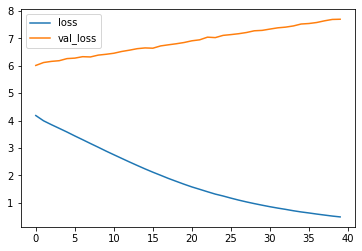

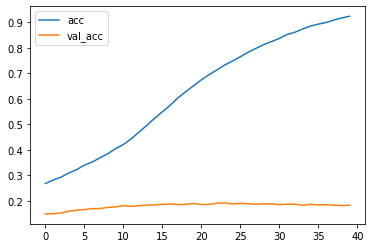

In [38]:
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])




r = model.fit(
  [ip_encdr, ip_dcdr], trgt_dcdrs1_hot,
  batch_size=n_size_batch,
  epochs=nepochs,
  validation_split=0.2,
)


plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
import keras.losses
keras.losses.custom_loss = custom_loss

model = tf.keras.models.load_model('/content/drive/My Drive/seq_to_seq98.h5')

#Making Predictions

In [39]:

encoder_model = Model(ip_encdr_plshldr, encoder_states)

ip_state_dcdr_h = Input(shape=(dim_latent,))
ip_state_dcdr_c = Input(shape=(dim_latent,))
ip_states_dcdr = [ip_state_dcdr_h, ip_state_dcdr_c]


single_ip_dcdr = Input(shape=(1,))
single_ip_dcdr_x = decoder_embedding(single_ip_dcdr)


op_dcdr, h, c = decoder_lstm(
  single_ip_dcdr_x,
  initial_state=ip_states_dcdr
)

states_dcdr = [h, c]

op_dcdr = dense_dcdr(op_dcdr)


model_dcdr = Model(
  [single_ip_dcdr] + ip_states_dcdr, 
  [op_dcdr] + states_dcdr
)

idx2word_eng = {v:k for k, v in inputs_w2ind.items()}
idx2word_trans = {v:k for k, v in outputs_w2ind.items()}

def dcdr_seq(input_seq):
  
  val_states = encoder_model.predict(input_seq)

  
  seq_trgt = np.zeros((1, 1))


  seq_trgt[0, 0] = outputs_w2ind['<sos>']

  
  eos = outputs_w2ind['<eos>']

  
  sent_op = []
  for _ in range(trgt_lenth_mx):
    tkns_op, h, c = model_dcdr.predict(
      [seq_trgt] + val_states
    )
    
    ind = np.argmax(tkns_op[0, 0, :])

  
    if eos == ind:
      break

    word = ''
    if ind > 0:
      word = idx2word_trans[ind]
      sent_op.append(word)

    
    seq_trgt[0, 0] = ind

    
    val_states = [h, c]
    

  return ' '.join(sent_op)


  
    
  






#Model Summarry

In [40]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 22)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 22, 100)      243000      ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        multiple             319600      ['input_4[0][0]']                
                                                                                            

# Testing Translations

In [41]:
while True:
    i = np.random.choice(len(sentences_inputs))
    input_seq = ip_encdr[i:i+1]
    translation = dcdr_seq(input_seq)
    print('--------------------------')
    print('English i/p:', sentences_inputs[i])
    print('Hindi Translated O/p:', translation)

    response = input("press  n  to exit         ")
    if response and response.lower().startswith('n'):
      break
    

--------------------------
English i/p: Unbelievable!
Hindi Translated O/p: अविश्वसनीय!
press  n  to exit         y
--------------------------
English i/p: Is anybody here?
Hindi Translated O/p: कोई है क्या?
press  n  to exit         y
--------------------------
English i/p: He hesitated for a moment.
Hindi Translated O/p: उसने थोड़ी देर हिचकिचाया।
press  n  to exit         y
--------------------------
English i/p: Clean the room.
Hindi Translated O/p: कमरे को साफ़ करो।
press  n  to exit         y
--------------------------
English i/p: May I go ahead of you?
Hindi Translated O/p: क्या मैं आपसे आगे चली जाऊं?
press  n  to exit         y
--------------------------
English i/p: Do I have to stay in the hospital?
Hindi Translated O/p: क्या मुझे अस्पताल में रहना होगा?
press  n  to exit         y
--------------------------
English i/p: We hurried to the train station.
Hindi Translated O/p: हम जल्दबाज़ी में ट्रेन स्टेशन गए।
press  n  to exit         y
--------------------------
English i/p: I